In [12]:
!pip install ultralytics roboflow pillow

In [13]:
from ultralytics import YOLO
from roboflow import Roboflow
import os
from google.colab import files
import shutil
from pathlib import Path

In [14]:
rf = Roboflow(api_key="xxxx")  # Replace with your Roboflow API key
project = rf.workspace("normal-bones").project("bone-cancer-detection-xa7ru")
dataset = project.version(1).download("multiclass")

print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /content/bone-cancer-detection--1


In [15]:
# Cell 4: Organize Dataset for YOLO Classification
# -------------------------------------------------
# YOLO classification needs this structure:
# dataset/
#   train/
#     class1/
#       img1.jpg
#       img2.jpg
#     class2/
#       img1.jpg
#   val/
#     class1/
#     class2/

dataset_path = dataset.location

# Check current structure
print("Current dataset structure:")
print(f"Train images: {len(list(Path(dataset_path + '/train').glob('*.jpg')))}")
print(f"Valid images: {len(list(Path(dataset_path + '/valid').glob('*.jpg')))}")
print(f"Test images: {len(list(Path(dataset_path + '/test').glob('*.jpg')))}")

# For multiclass format, images should already be organized or we need to organize them
# Let's check if subdirectories exist
train_subdirs = [d for d in Path(dataset_path + '/train').iterdir() if d.is_dir()]
print(f"\nTrain subdirectories: {train_subdirs}")


Current dataset structure:
Train images: 7057
Valid images: 882
Test images: 872

Train subdirectories: []


In [16]:
# Cell 5: Create Proper Dataset Structure (if needed)
# ----------------------------------------------------
# If images are NOT in class subdirectories, we need to organize them
# based on filename patterns or create folders manually

# Check if we need to reorganize
if len(train_subdirs) == 0:
    print("⚠️ Images are not organized in class folders.")
    print("We need to organize them based on the dataset metadata.")

    # Option 1: Check if there's a CSV or metadata file
    metadata_files = list(Path(dataset_path).glob('*.csv'))
    print(f"Metadata files found: {metadata_files}")

    # Option 2: Parse filenames (many Roboflow datasets encode class in filename)
    # For now, let's assume we need to organize manually
    # You'll need to tell me the class names from your dataset

    print("\n📋 Please check your Roboflow project page for class names.")
    print("Then create folders manually or provide the class information.")
else:
    print(f"✅ Dataset is properly organized with {len(train_subdirs)} classes")
    class_names = [d.name for d in train_subdirs]
    print(f"Classes found: {class_names}")

⚠️ Images are not organized in class folders.
We need to organize them based on the dataset metadata.
Metadata files found: []

📋 Please check your Roboflow project page for class names.
Then create folders manually or provide the class information.


In [18]:
# Cell 5.5: Check Dataset Organization & Fix It
# ----------------------------------------------
import os
import shutil
from pathlib import Path

dataset_path = "/content/bone-cancer-detection--1"

# First, let's see the actual file structure
print("Checking a few image filenames for patterns:")
train_images = list(Path(f"{dataset_path}/train").glob("*.jpg"))[:10]
for img in train_images:
    print(img.name)

print("\n" + "="*60)

# Check if there's a _classes.csv or any metadata file
print("Looking for metadata files:")
!find {dataset_path} -name "*.csv" -o -name "*.json" -o -name "*class*"

print("\n" + "="*60)

# Check README files for class information
readme_files = list(Path(dataset_path).glob("README*"))
for readme in readme_files:
    print(f"\n{readme.name}:")
    with open(readme, 'r') as f:
        content = f.read()
        print(content[:500])  # Print first 500 chars

Checking a few image filenames for patterns:
bone-cancer_train_2_2275_png.rf.4c72c1ff8a71154727bdb76518435ed6.jpg
bone-cancer_train_2_179_png.rf.1d5df72bfae31d1d7e212e4f70af5ba9.jpg
bone-cancer_train_2_1903_png.rf.f47377fe57e8eed8b194f33975cf903b.jpg
bone-cancer_valid_186_png.rf.2b19e89a64f3f5224a9562432fe23c37.jpg
IMG0000335_jpg.rf.64f0f39eed2d74405cef1a4bac36f4d0.jpg
image-no562-normal-_png.rf.d2158fb6a9ed026fb2d36ecfb0ccf4a6.jpg
bone-cancer_train_2_2450_png.rf.c231231bacbe70bc35cd2961eebb60e6.jpg
IMG0000626_jpg.rf.d709d091113c456570ecba8a6a9792c6.jpg
bone-cancer_train_2_1302_png.rf.7baed2d1b266dfcc3e167d044c980e4a.jpg
IMG_0128_JPG_jpg.rf.da4d1cd8c38ec7bc617452b6b3e90758.jpg

Looking for metadata files:
/content/bone-cancer-detection--1/train/_classes.csv
/content/bone-cancer-detection--1/valid/_classes.csv
/content/bone-cancer-detection--1/test/_classes.csv


README.dataset.txt:
# bone cancer detection  > 2024-05-04 11:22am
https://universe.roboflow.com/normal-bones/bone-cancer-dete

In [19]:
# Cell 5.5: Read Class Information and Organize Dataset
# ------------------------------------------------------
import pandas as pd
import shutil
from pathlib import Path
import os

dataset_path = "/content/bone-cancer-detection--1"

# Read the classes CSV
train_csv = pd.read_csv(f"{dataset_path}/train/_classes.csv")
print("Train classes CSV:")
print(train_csv.head(20))
print(f"\nTotal train images: {len(train_csv)}")
print(f"Columns: {train_csv.columns.tolist()}")
print(f"\nUnique classes: {train_csv.iloc[:, 1].unique() if len(train_csv.columns) > 1 else 'Need to check structure'}")

# Check valid CSV too
valid_csv = pd.read_csv(f"{dataset_path}/valid/_classes.csv")
print(f"\n{'='*60}")
print("Valid classes CSV:")
print(valid_csv.head(20))

# Check test CSV
test_csv = pd.read_csv(f"{dataset_path}/test/_classes.csv")
print(f"\n{'='*60}")
print("Test classes CSV:")
print(test_csv.head(20))

Train classes CSV:
                                             filename   cancer   normal
0    -53-_jpg.rf.08d303d0b43c7b71c3581ec02d7390c3.jpg        0        1
1   image-no531-normal-_png.rf.08eeb57b24a9062d798...        0        1
2   IMG0000240_jpg.rf.094924a72ca1ab5e26477e50abac...        0        1
3   bone-cancer_train_2_821_png.rf.094c60132af2cb3...        1        0
4   image-no52-normal-_png.rf.08f33a992911794d2381...        0        1
5   bone-cancer_train_2_2322_png.rf.088e4d5a855c07...        1        0
6   fibula_osteosarcoma_18_PNG.rf.08cfa297f7fbcdf9...        1        0
7   IMG0000733_jpg.rf.0947da3fcdbdb932300020a294f8...        0        1
8   bone-cancer_valid_2_360_png.rf.0893bb0f1f80f00...        1        0
9   image-no87-normal-_png.rf.09468b7b34fb724140ee...        0        1
10  IMG0000679_jpg.rf.0960227f4630be0d5e5f8087859e...        0        1
11  IMG0000679_jpg.rf.091c2410ad59d5344b9278f6e048...        0        1
12  image-no607-normal-_png.rf.08ad77c36a759e

In [21]:
# Cell 5.5: Organize Images into Class Folders
# ---------------------------------------------
import pandas as pd
import shutil
from pathlib import Path
import os

dataset_path = "/content/bone-cancer-detection--1"

def organize_images(split_name):
    """Organize images from flat structure into class folders"""

    # Read CSV
    csv_path = f"{dataset_path}/{split_name}/_classes.csv"
    df = pd.read_csv(csv_path)

    # Clean column names (remove spaces)
    df.columns = df.columns.str.strip()

    # Create class folders
    split_path = Path(dataset_path) / split_name
    cancer_folder = split_path / "cancer"
    normal_folder = split_path / "normal"

    cancer_folder.mkdir(exist_ok=True)
    normal_folder.mkdir(exist_ok=True)

    # Move images to appropriate folders
    moved_cancer = 0
    moved_normal = 0

    for idx, row in df.iterrows():
        filename = row['filename']
        is_cancer = row['cancer']
        is_normal = row['normal']

        src_path = split_path / filename

        if not src_path.exists():
            print(f"Warning: {filename} not found")
            continue

        # Move to appropriate class folder
        if is_cancer == 1:
            dst_path = cancer_folder / filename
            shutil.move(str(src_path), str(dst_path))
            moved_cancer += 1
        elif is_normal == 1:
            dst_path = normal_folder / filename
            shutil.move(str(src_path), str(dst_path))
            moved_normal += 1

    print(f"{split_name.upper()}:")
    print(f"  ✅ Moved {moved_cancer} images to cancer/")
    print(f"  ✅ Moved {moved_normal} images to normal/")

    # Remove the CSV file (no longer needed)
    os.remove(csv_path)

    return moved_cancer, moved_normal

# Organize all splits
print("Organizing dataset into class folders...\n")
organize_images('train')
organize_images('valid')
organize_images('test')

print("\n" + "="*60)
print("✅ Dataset reorganized successfully!\n")

# Verify the new structure
print("New structure:")
print(f"Train - cancer: {len(list((Path(dataset_path)/'train'/'cancer').glob('*.jpg')))}")
print(f"Train - normal: {len(list((Path(dataset_path)/'train'/'normal').glob('*.jpg')))}")
print(f"Valid - cancer: {len(list((Path(dataset_path)/'valid'/'cancer').glob('*.jpg')))}")
print(f"Valid - normal: {len(list((Path(dataset_path)/'valid'/'normal').glob('*.jpg')))}")
print(f"Test - cancer: {len(list((Path(dataset_path)/'test'/'cancer').glob('*.jpg')))}")
print(f"Test - normal: {len(list((Path(dataset_path)/'test'/'normal').glob('*.jpg')))}")


Organizing dataset into class folders...

TRAIN:
  ✅ Moved 3081 images to cancer/
  ✅ Moved 3976 images to normal/
VALID:
  ✅ Moved 398 images to cancer/
  ✅ Moved 484 images to normal/
TEST:
  ✅ Moved 384 images to cancer/
  ✅ Moved 488 images to normal/

✅ Dataset reorganized successfully!

New structure:
Train - cancer: 3081
Train - normal: 3976
Valid - cancer: 398
Valid - normal: 484
Test - cancer: 384
Test - normal: 488


In [22]:

model = YOLO('yolov8n-cls.pt')  # Nano classification model

# Cell 7: Train the Classification Model
# ---------------------------------------
results = model.train(
    data=dataset_path,           # Point to dataset root (not data.yaml for classification)
    epochs=50,                    # Adjust based on your needs
    imgsz=224,                    # Standard classification image size (224 or 640)
    batch=32,                     # Can use larger batch for classification
    name='bone_cancer_classifier',
    patience=10,                  # Early stopping
    save=True,
    device=0,                     # GPU
    workers=2,
    project='runs/classify',
    optimizer='auto',
    verbose=True,
    seed=42,
    pretrained=True,
    lr0=0.01,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    plots=True,
    val=True,                     # Enable validation
)


Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/bone-cancer-detection--1, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=bone_cancer_classifier2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, persp

In [24]:
# Validate on test set
metrics = model.val()

print(f"\n📊 Validation Results:")
print(f"Top-1 Accuracy: {metrics.top1:.4f}")
print(f"Top-5 Accuracy: {metrics.top5:.4f}")

# Cell 9: View Training Results
# ------------------------------
from IPython.display import Image, display

# Display training curves
results_path = 'runs/classify/bone_cancer_classifier'
if os.path.exists(f'{results_path}/results.png'):
    print("Training Results:")
    display(Image(f'{results_path}/results.png'))

if os.path.exists(f'{results_path}/confusion_matrix.png'):
    print("\nConfusion Matrix:")
    display(Image(f'{results_path}/confusion_matrix.png'))


Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
train: /content/bone-cancer-detection--1/train... found 7057 images in 2 classes ✅ 
val: /content/bone-cancer-detection--1/valid... found 882 images in 2 classes ✅ 
test: /content/bone-cancer-detection--1/test... found 872 images in 2 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 858.9±401.3 MB/s, size: 29.5 KB)
val: Scanning /content/bone-cancer-detection--1/valid... 882 images, 0 corrupt: 100% ━━━━━━━━━━━━ 882/882 246.6Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 56/56 8.4it/s 6.7s
                   all      0.985          1
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val2

📊 Validation Results:
Top-1 Accuracy: 0.9853
Top-5 Accuracy: 1.0000


In [26]:
# Test on validation images
import glob

# Collect all image paths from the 'valid' split's subdirectories
valid_image_paths = []
# Assuming 'cancer' and 'normal' are the class names based on previous organization steps
class_names = ['cancer', 'normal']

for class_name in class_names:
    path_pattern_jpg = f"{dataset_path}/valid/{class_name}/*.jpg"
    path_pattern_png = f"{dataset_path}/valid/{class_name}/*.png" # Include PNGs if present
    valid_image_paths.extend(glob.glob(path_pattern_jpg))
    valid_image_paths.extend(glob.glob(path_pattern_png))

# Limit to a few images for demonstration, or remove slicing to predict on all
source_for_predict = valid_image_paths[:10] if len(valid_image_paths) > 10 else valid_image_paths

test_results = model.predict(
    source=source_for_predict, # Pass the list of image paths
    save=True,
    conf=0.25,
    name='test_predictions_on_valid' # Changed name to differentiate from previous runs
)

# Show some predictions
print("\nSample Predictions:")
for r in test_results[:5]:
    probs = r.probs.data
    top1_idx = probs.argmax()
    top1_conf = probs[top1_idx]
    print(f"Image: {r.path}")
    print(f"Predicted class: {model.names[int(top1_idx)]} (confidence: {top1_conf:.2%})\n")


0: 224x224 cancer 1.00, normal 0.00, 2.1ms
1: 224x224 cancer 1.00, normal 0.00, 2.1ms
2: 224x224 cancer 1.00, normal 0.00, 2.1ms
3: 224x224 cancer 1.00, normal 0.00, 2.1ms
4: 224x224 cancer 1.00, normal 0.00, 2.1ms
5: 224x224 cancer 1.00, normal 0.00, 2.1ms
6: 224x224 cancer 1.00, normal 0.00, 2.1ms
7: 224x224 cancer 0.89, normal 0.11, 2.1ms
8: 224x224 cancer 0.67, normal 0.33, 2.1ms
9: 224x224 cancer 1.00, normal 0.00, 2.1ms
Speed: 5.0ms preprocess, 2.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /content/runs/classify/test_predictions_on_valid

Sample Predictions:
Image: /content/bone-cancer-detection--1/valid/cancer/IMG_1803_JPG_jpg.rf.8540039e1b6abcc395ebe27f583b1aa5.jpg
Predicted class: cancer (confidence: 100.00%)

Image: /content/bone-cancer-detection--1/valid/cancer/IMG_2403_JPG_jpg.rf.804e0ec2dcc2681323b79753e09e0a86.jpg
Predicted class: cancer (confidence: 99.95%)

Image: /content/bone-cancer-detection--1/valid/cancer/hand_metastasis_2

In [29]:
# Cell 11: Save the Best Model
# -----------------------------
# Get the actual save directory from the training results object
actual_save_dir = results.save_dir
best_model_path = Path(actual_save_dir) / 'weights' / 'best.pt'
print(f"Best model saved at: {best_model_path}")

# Copy to simpler location
# Ensure the target directory for 'best.pt' exists, if not, it will be saved in /content
!cp {best_model_path} best.pt

print("✅ Training complete! Model saved as 'best.pt'")

# Cell 12: Download Model
# ------------------------
files.download('best.pt')

# Also download training results
# Update results_path to the actual save directory for zipping
actual_results_path_for_zip = str(actual_save_dir).split('/content/')[-1] # Convert to string before splitting
!zip -r training_results.zip {actual_results_path_for_zip}
files.download('training_results.zip')

print("✅ Files downloaded!")

Best model saved at: /content/runs/classify/runs/classify/bone_cancer_classifier2/weights/best.pt
✅ Training complete! Model saved as 'best.pt'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: runs/classify/runs/classify/bone_cancer_classifier2/ (stored 0%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/val_batch0_pred.jpg (deflated 10%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/train_batch8842.jpg (deflated 10%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/val_batch1_labels.jpg (deflated 11%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/confusion_matrix.png (deflated 36%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/train_batch0.jpg (deflated 17%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/weights/ (stored 0%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/weights/best.pt (deflated 9%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/weights/last.pt (deflated 9%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/results.png (deflated 10%)
  adding: runs/classify/runs/classify/bone_cancer_classifier2/train_batch8841.jpg (d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files downloaded!



image 1/1 /content/bone-cancer-detection--1/valid/normal/image-no163-normal-_png.rf.2316e756cb781428f21f10ba5fba2b58.jpg: 224x224 normal 1.00, cancer 0.00, 3.3ms
Speed: 7.2ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


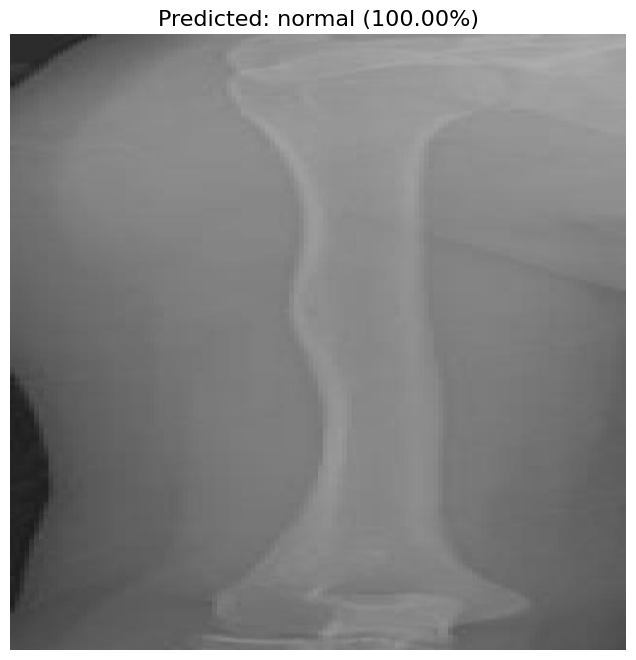


🎯 Prediction: normal
📊 Confidence: 100.00%

All class probabilities:
  cancer: 0.00%
  normal: 100.00%


In [30]:
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Load model
model = YOLO('best.pt')

# Predict on a single image from validation set
test_img_path = list(Path(f"{dataset_path}/valid").glob('**/*.jpg'))[0]
results = model.predict(test_img_path)

# Display result
img = PILImage.open(test_img_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')

# Get prediction
probs = results[0].probs
top1_idx = probs.data.argmax()
top1_conf = probs.data[top1_idx]
predicted_class = model.names[int(top1_idx)]

plt.title(f"Predicted: {predicted_class} ({top1_conf:.2%})", fontsize=16)
plt.show()

print(f"\n🎯 Prediction: {predicted_class}")
print(f"📊 Confidence: {top1_conf:.2%}")
print("\nAll class probabilities:")
for idx, prob in enumerate(probs.data):
    print(f"  {model.names[idx]}: {prob:.2%}")
